In [23]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [42]:

def generative_process(T=20):
    x = [np.random.normal()]
    for t in range(1,T):
        x.append(x[0])
    return np.array(x)


def model_process(t=20):
    # generate each time step from standard normal distribution for t time steps
    x = np.random.normal(size=t)
    return x

#def generative_trajectories(n=100, t=20):
    
 #   traj = np.array([generative_process(t) for _ in range(n)])
    
  #  return traj


#def model_trajectories(n=100, t=20):
    
 #   traj = np.array([model_process(t) for _ in range(n)])
    
  #  return traj



def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [43]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


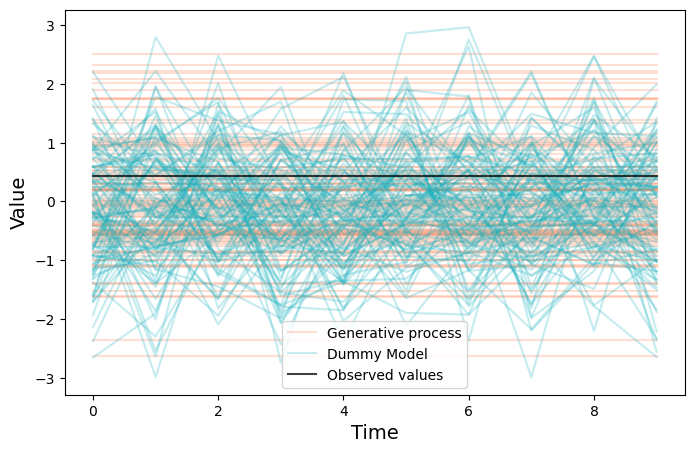

In [22]:
fig, axes = plt.subplots(figsize=(8, 5))
g1 = generative_trajectories(n=100)
g2 = model_trajectories(n=100)
g2['trajectory_id'] = g2['trajectory_id'] + 100
g = pd.concat([g1, g2])

for i in g.trajectory_id.unique():
    gf = g[g.trajectory_id == i]
    
    if i <100:
        color = 'coral'
        
    else:
        color =  '#17B1BF'
        
    #plt.plot(range(10), gf['value'], color = color, alpha = .25)
    
    if i ==1:
        plt.plot(range(10), gf['value'], color = color, alpha = .25, label ='Generative process')
    elif i==110:
        plt.plot(range(10), gf['value'], color = color, alpha = .25, label='Dummy Model')
    else:
        plt.plot(range(10), gf['value'], color = color, alpha = .25)

plt.plot(range(10), generative_process(), color = 'k', alpha = .75, label='Observed values')
    

    
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.legend()

#plt.savefig('trajectories_test_flat.pdf')
plt.show()

In [68]:
N = 1000
M = 20

numit = 1000

ES1 = []
ES2 = []
WIS1 = []
WIS2 = []

for _ in range(numit):
    y = generative_process(M)
    X1 = np.array([generative_process(M) for _ in range(N)])
    X2 = np.array([model_process(M) for _ in range(N)])
    ES1.append(energyscore(X1,y))
    ES2.append(energyscore(X2,y))
    WIS1.append(WIS(X1,y))
    WIS2.append(WIS(X2,y))
ES1_mean = np.mean(ES1)
ES2_mean = np.mean(ES2)
WIS1_mean = np.mean(WIS1)
WIS2_mean = np.mean(WIS2)

In [70]:
print('model ES = ' + str(ES2_mean))
print('generative ES = ' + str(ES1_mean))

print('model WIS = ' + str(WIS2_mean))
print('generative WIS = ' + str(WIS1_mean))

model ES = 2.8448665712419725
generative ES = 2.4894606797453007
model WIS = 9.96566202288819
generative WIS = 9.948001595078955


In [64]:
X1 = np.array([generative_process(10) for _ in range(N)])
X2 = np.array([model_process(10) for _ in range(N)])

dftot = pd.DataFrame()
for model in ['generative', 'model']:
    if model == 'generative':
        dat = X1
    else:
        dat = X2
    for i in range(len(X1)):
        df = pd.DataFrame(dat[i], columns = ['value'])
        df['time'] = [1,2,3,4,5,6,7,8,9,10]
        
        df['Model'] = model
        dftot=pd.concat([dftot, df])

In [65]:
dftot

,value,time,Model
0,0.207477,1,generative
1,0.207477,2,generative
2,0.207477,3,generative
3,0.207477,4,generative
4,0.207477,5,generative
...,...,...,...
5,-0.097523,6,model
6,0.692145,7,model
7,0.771185,8,model
8,-0.825529,9,model


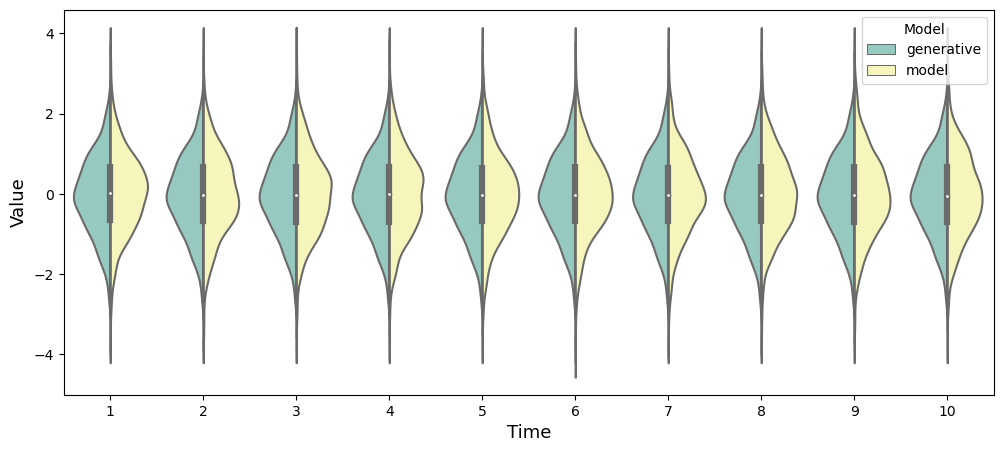

In [67]:
# plot distributions at each time step
fig, axes = plt.subplots(figsize=(12, 5))

sns.violinplot(x="time", y="value", hue="Model",
            data=dftot, split=True, palette='Set3')

plt.xlabel('Time', fontsize=13)
plt.ylabel('Value',fontsize=13)
axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

plt.savefig('marginaldist.pdf')
plt.show()

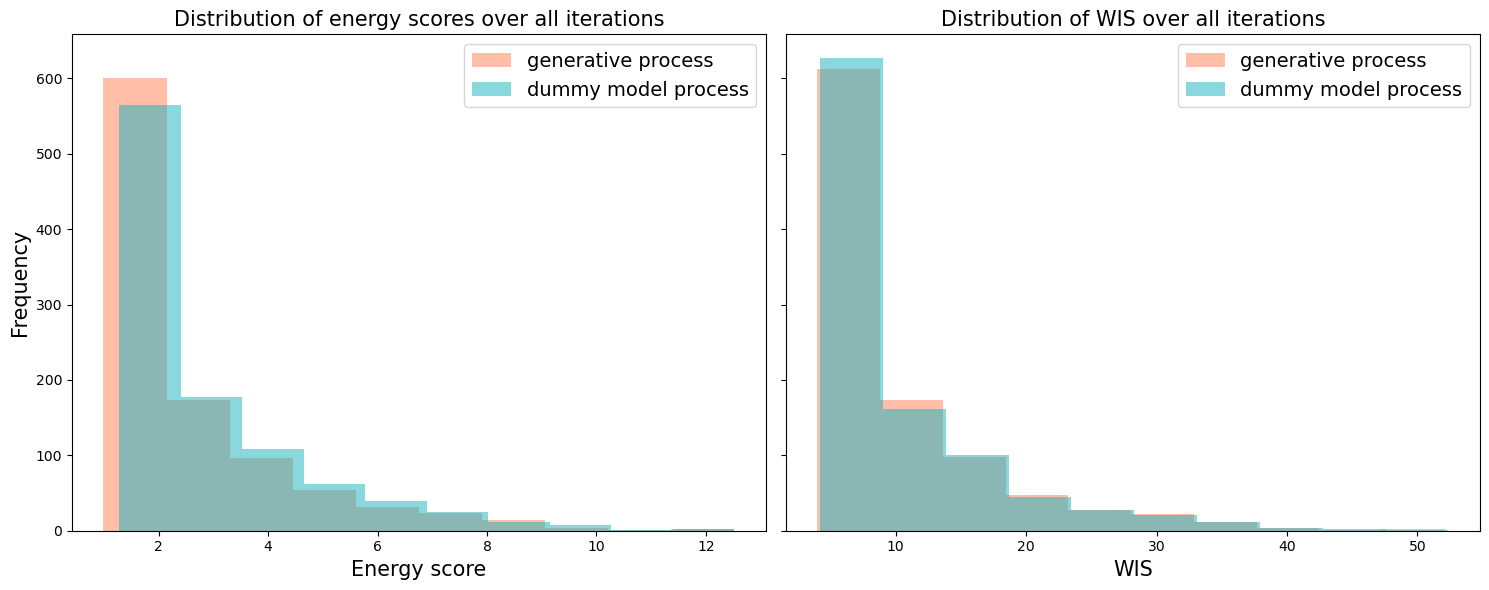

In [86]:
fig = plt.subplots(1,2,figsize=(15, 6), sharey=True)

plt.subplot(1,2,1)

plt.hist(ES1,alpha=0.5,color = 'coral', label='generative process')
plt.hist(ES2,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('Energy score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of energy scores over all iterations', fontsize=15)
plt.legend(fontsize=14)

plt.subplot(1,2,2)

plt.hist(WIS1,alpha=0.5,color = 'coral', label='generative process')
plt.hist(WIS2,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('WIS', fontsize=15)
#plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of WIS over all iterations', fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('distofscores.png')
plt.show()

In [116]:
# increasing/decreasing processes

In [90]:
def generative_process_inc(t=10):
    # generate a flat line drawn from a standard normal distribution with length t
    v = []
    init = np.random.normal()
    for i in range(t):
        v.append(init*(i+1))
        
    v = np.array(v)
    
    return v


def model_process_inc(t=10):
    # generate each time step from standard normal distribution for t time steps
    v = []
    for i in range(t):
        v.append(np.random.normal(0, i+1))
        
    v = np.array(v)
        
    return v


def generative_trajectories_inc(n=100, t=10):
    dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        init = np.random.normal()
        for i in range(t):
            v.append(init*(i+1))
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'generative'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj


def model_trajectories_inc(n=100, t=10):
    dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
    traj = pd.DataFrame()
    for j in range(n):
        v = []
        for i in range(t):
            v.append(np.random.normal(0,i+1))
        
        v1 = pd.DataFrame({'value':v, 'target_end_date':dates})
        v1['Model'] = 'model'
        v1['trajectory_id'] = j
        
        traj = pd.concat([traj, v1])
    return traj

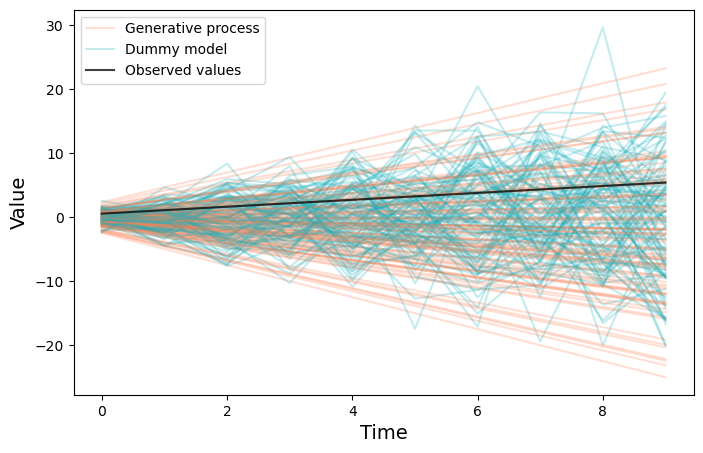

In [103]:
fig, axes = plt.subplots(figsize=(8, 5))



nb_sample = 100
for i in range(nb_sample):
    plt.plot(generative_process_inc(), color='coral', label='Generative process' if i == 0 else None, alpha=.25)
    plt.plot(model_process_inc(), color='#17B1BF', label='Dummy model' if i == 0 else None, alpha=.25)

plt.plot(range(10), generative_process_inc(), color = 'k', alpha = .75, label='Observed values')

plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.legend()

plt.savefig('trajectories_test_inc.png')
plt.show()

In [108]:
N=1000
X1 = np.array([generative_process_inc(10) for _ in range(N)])
X2 = np.array([model_process_inc(10) for _ in range(N)])

dftot = pd.DataFrame()
for model in ['generative', 'model']:
    if model == 'generative':
        dat = X1
    else:
        dat = X2
    for i in range(len(X1)):
        df = pd.DataFrame(dat[i], columns = ['value'])
        df['time'] = [1,2,3,4,5,6,7,8,9,10]
        
        df['Model'] = model
        dftot=pd.concat([dftot, df])


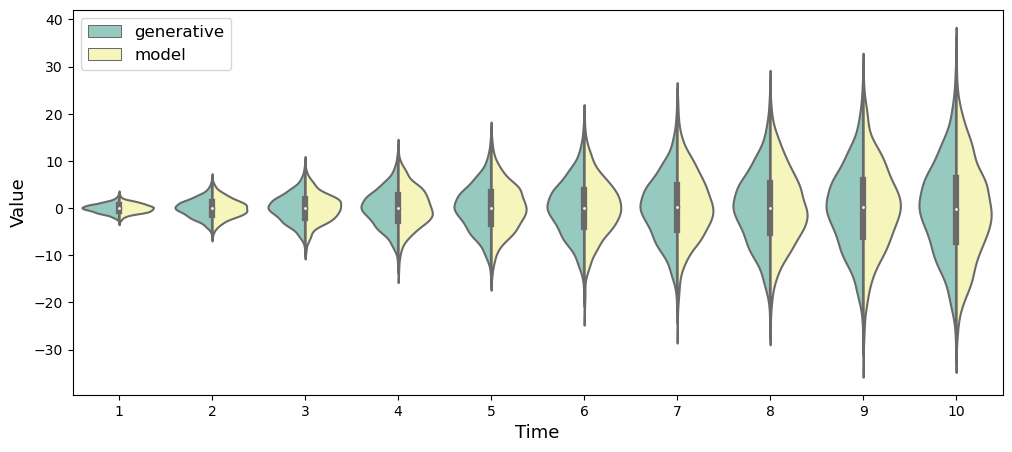

In [115]:
# plot distributions at each time step
fig, axes = plt.subplots(figsize=(12, 5))

sns.violinplot(x="time", y="value", hue="Model",
            data=dftot, split=True, palette='Set3')

plt.xlabel('Time', fontsize=13)
plt.ylabel('Value',fontsize=13)
axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10])

plt.legend(loc='upper left', fontsize=12)
plt.savefig('marginaldist_inc.png')
plt.show()

In [116]:
N = 1000
M = 20

numit = 1000

ES1 = []
ES2 = []
WIS1 = []
WIS2 = []

for _ in range(numit):
    y = generative_process_inc(M)
    X1 = np.array([generative_process_inc(M) for _ in range(N)])
    X2 = np.array([model_process_inc(M) for _ in range(N)])
    ES1.append(energyscore(X1,y))
    ES2.append(energyscore(X2,y))
    WIS1.append(WIS(X1,y))
    WIS2.append(WIS(X2,y))
ES1_mean = np.mean(ES1)
ES2_mean = np.mean(ES2)
WIS1_mean = np.mean(WIS1)
WIS2_mean = np.mean(WIS2)

In [118]:
print('model ES = ' + str(ES2_mean))
print('generative ES = ' + str(ES1_mean))

print('model WIS = ' + str(WIS2_mean))
print('generative WIS = ' + str(WIS1_mean))

model ES = 34.96042880628862
generative ES = 30.936848421444413
model WIS = 108.18889391375455
generative WIS = 108.36279978442518


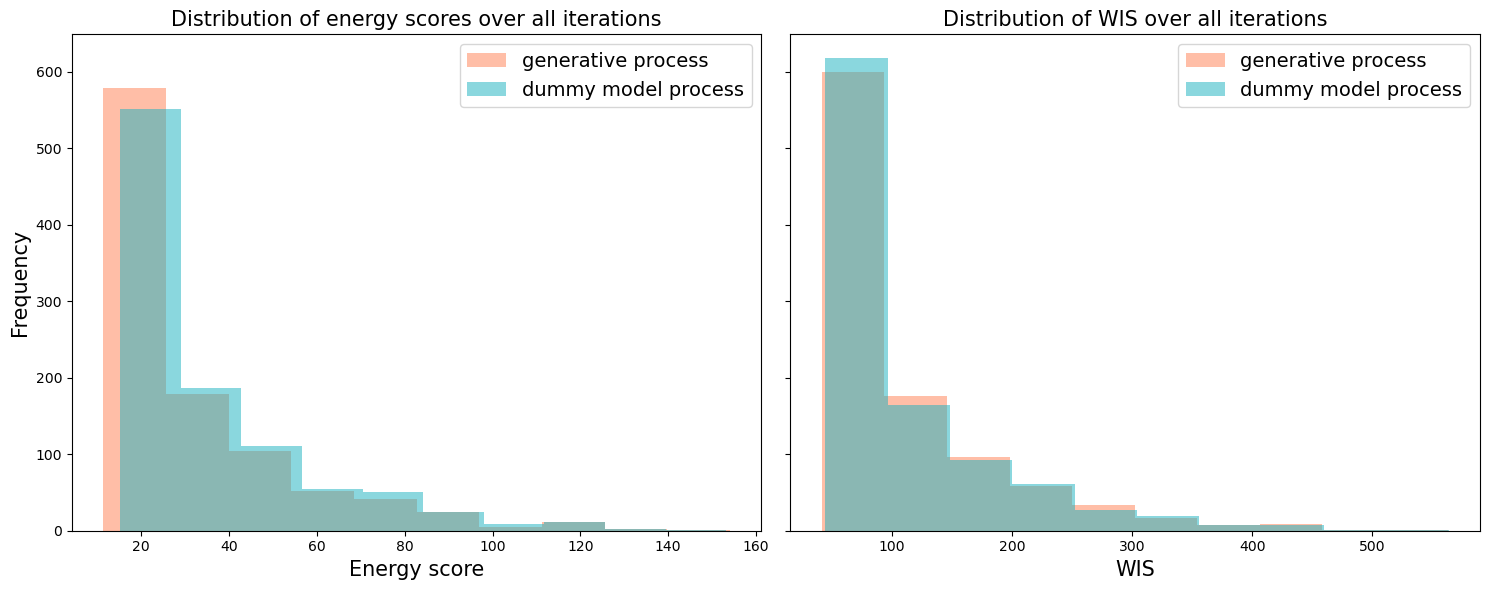

In [126]:
fig = plt.subplots(1,2,figsize=(15, 6), sharey=True)

plt.subplot(1,2,1)

plt.hist(ES1,bins=10,alpha=0.5,color = 'coral', label='generative process')
plt.hist(ES2,bins=10,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('Energy score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of energy scores over all iterations', fontsize=15)
plt.legend(fontsize=14)

plt.subplot(1,2,2)

plt.hist(WIS1,bins=10,alpha=0.5,color = 'coral', label='generative process')
plt.hist(WIS2,bins=10,alpha=0.5, color = '#17B1BF', label = 'dummy model process')

plt.xlabel('WIS', fontsize=15)
#plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of WIS over all iterations', fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()

#plt.savefig('distofscores_inc.png')
plt.show()

# old code:

In [286]:
dates = pd.to_datetime(['2023-04-22', '2023-04-29', '2023-05-06', '2023-05-13', '2023-05-20', '2023-05-27',
                            '2023-06-03', '2023-06-10', '2023-06-17', '2023-06-24'])
N = 200
M = 10

es_out = pd.DataFrame()
wis_out = pd.DataFrame()
for i in range(100):
    for model in ['model', 'generative']:

        gfilt = g[g.Model ==model]
        # first term
        obs = generative_process()
        observations = pd.DataFrame({'value':obs, 'target_end_date':dates})
        pfilt = gfilt.merge(observations, how='left', on=['target_end_date'])
        pfilt['diff_sq']=(pfilt.value_x - pfilt.value_y)**2

        ES1 = 1/N*sum(np.sqrt(np.array(pfilt.groupby(['trajectory_id']).sum()['diff_sq'])))


        # second term

        cross = gfilt.merge(gfilt, how='cross')
        crossfilt = cross.loc[(cross['target_end_date_x'] == cross['target_end_date_y']) ]

        crossfilt['diff_sq'] = (crossfilt.value_x - crossfilt.value_y)**2
        ES2 = 1/(2*N**2) * sum(np.sqrt(np.array(crossfilt.groupby(['trajectory_id_x',
                                                                   'trajectory_id_y']).sum()['diff_sq'])))

        ES = ES1 - ES2

        es = pd.DataFrame({'Model':model, 'ES':ES, 'iteration':i}, index=[0])
        es_out = pd.concat([es_out, es])
        
        
        # calculate WIS

        # transform trajectories into quantiles
        quants = [.01, .025, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8,
                  .85, .9, .95, .975, .99]

        quantdf = pd.DataFrame()
        for q in quants:
            qval = list(gfilt.groupby('target_end_date')['value'].quantile(q))

            qdf = pd.DataFrame({'value':qval, 'target_end_date':dates})
            qdf['quantile'] = q
            qdf['Model'] = model

            quantdf = pd.concat([quantdf, qdf])

        gg = Predictions(quantdf, t_col='target_end_date')
        d = score_utils.all_timestamped_scores_from_df(Observations(observations, t_col = 'target_end_date'), gg)

        wisvals = list(d['wis'])

        wis_df = pd.DataFrame({'wis':wisvals, 'target_end_date':dates})
        wis_df['Model'] = model
        wis_df['iteration'] = i
        
        wis_out = pd.concat([wis_out, wis_df])


es_out = es_out.reset_index()
es_out = es_out.drop(columns=['index'])   

In [287]:
wissumdf = pd.DataFrame()
for it in wis_out.iteration.unique():
    for model in ['model', 'generative']:

        s = wis_out[(wis_out.iteration == it)& (wis_out.Model==model)]['wis'].sum()
        
        ws = pd.DataFrame({'wis_sum':s, 'Model':model, 'iteration':it}, index = [0])
        
        wissumdf = pd.concat([wissumdf, ws])
        
wissumdf = wissumdf.reset_index()
wissumdf = wissumdf.drop(columns=['index'])   

In [288]:
print('model WIS = ' + str(wissumdf[wissumdf.Model =='model'].wis_sum.mean()))
print('generative WIS = ' + str(wissumdf[wissumdf.Model =='generative'].wis_sum.mean()))

model WIS = 12.885544662520992
generative WIS = 12.115400489851329


In [289]:
print('model ES = ' + str(es_out[es_out.Model =='model'].ES.mean()))
print('generative ES = ' + str(es_out[es_out.Model =='generative'].ES.mean()))

model ES = 5.970283458117646
generative ES = 4.733499340180336


In [129]:
(62.33/6 -10)*60

23.30000000000002

In [130]:
165*5+178

1003

In [131]:
1003/6

167.16666666666666